# Overview 

This notebook describes how to run in silico TF perturbations with the GRN models. 
Please read our paper to learn more about the CellOracle algorithm.

### Notebook file
Notebook file is available at CellOracle GitHub.
https://github.com/morris-lab/CellOracle/blob/master/docs/notebooks/05_simulation/Gata1_KO_simulation_with_Paul_etal_2015_data.ipynb

### Data
In this notebook, CellOracle uses two types of input data.

- **Input data 1: Oracle object**. Please look at the previous notebook to learn how to make an `Oracle` object from scRNA-seq. https://morris-lab.github.io/CellOracle.documentation/notebooks/04_Network_analysis/Network_analysis_with_Paul_etal_2015_data.html

 In this tutorial, we will use the mouse hematopoiesis demo data (Paul et al., 2015). We can load the demo `Oracle` object using the command below.

 `oracle = co.data.load_tutorial_oracle_object()`


- **Input data 2: Links object**. The `Links` oobject stores the GRN data used in the simulations. In this tutorial, we use demo GRNs calculated from the hematopoiesis scRNA-seq data above and one of the mouse sci-ATAC-seq atlas base GRNs. We can load the demo `Links` object with this command.

 `links = co.data.load_tutorial_links_object()`

### What you can do
In this notebook, we perform two analyses.

1. **in silico TF perturbation** to simulate cell identity shifts. CellOracle uses the GRN model to simulate cell identity shifts in response to TF perturbations. For this analysis, you will need the GRN models from the previous notebook.

2. **Compare simulation vectors with developmental vectors**.  In order to properly interpret the simulation results, it is also important to consider the natural direction of development. First, we will calculate a pseudotime gradient vector field to recapitulate the developmental flow. Then, we will compare the CellOracle TF perturbation vector field with the developmental vector field by calculating the inner product scores. Let's call the inner product value as **perturbation score (PS)**. Please see the **step 5.6** for detail.
 
### Custom data class / object

In this notebook, CellOracle uses four custom classes, `Oracle`, `Links`, `Gradient_calculator`, and `Oracle_development_module`.

- `Oracle` is the main class in the CellOracle package.  It is responsible for most of the calculations during GRN model construction and TF perturbation simulations.

- `Links` is a class to store GRN data. 

- The `Gradient_calculator` calculates  the developmental vector field from the pseudotime results. If you do not have pseudotime data for your trajectory, please see the pseudotime notebook to calculate this information. https://morris-lab.github.io/CellOracle.documentation/tutorials/pseudotime.html

- The `Oracle_development_module` integrates the `Oracle` object data and the `Gradient_calculator` object data to analyze how TF perturbation affects on the developmental process. It also has many visualization functions.


# 0. Import libraries
## 0.1. Import public libraries

In [1]:
import os
import sys

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns


This notebook was made with celloracle version 0.10.5.
**Please use celloracle>=0.10.1** Otherwise, you may get an error.

In [2]:
import celloracle as co
co.__version__

2022-05-24 16:00:53,165 [31567] WARNING  py.warnings:99: [JupyterRequire] /home/k/anaconda3/envs/pandas1/lib/python3.6/site-packages/requests/__init__.py:91: RequestsDependencyWarning:

urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!




'0.10.5'

In [3]:
#plt.rcParams["font.family"] = "arial"
plt.rcParams["figure.figsize"] = [6,6]
%config InlineBackend.figure_format = 'retina'
plt.rcParams["savefig.dpi"] = 600

%matplotlib inline

## 0.1. Make a folder to save graph

In [4]:
# Make folder to save plots
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed oracle object

Load the oracle object. See the previous notebook for information on initializing an `Oracle` object.

In [5]:
# Load the tutorial oracle object. 
oracle = co.data.load_tutorial_oracle_object()
oracle

# Attention!! Please use the function below when you use your data. 
# oracle = co.load_hdf5("ORACLE OBJECT PATH")

Oracle object

Meta data
    celloracle version used for instantiation: 0.10.0
    n_cells: 2671
    n_genes: 1999
    cluster_name: louvain_annot
    dimensional_reduction_name: X_draw_graph_fa
    n_target_genes_in_TFdict: 21259 genes
    n_regulatory_in_TFdict: 1093 genes
    n_regulatory_in_both_TFdict_and_scRNA-seq: 90 genes
    n_target_genes_both_TFdict_and_scRNA-seq: 1850 genes
    k_for_knn_imputation: 66
Status
    Gene expression matrix: Ready
    BaseGRN: Ready
    PCA calculation: Done
    Knn imputation: Done
    GRN calculation for simulation: Not finished

## 1.2. Load inferred GRNs

In the previous notebook, we calculated the GRNs. Now, we will use these GRNs for the perturbation simulations. First, we will import the GRNs from the `Links` object.

In [6]:
# Here, we load demo links object for the training purpose.
links = co.data.load_tutorial_links_object()

# Attention!! Please use the function below when you use your data.
# links = co.load_hdf5("YOUR LINK OBJCT PATH")

# 2. Make predictive models for simulation

Here, we will need to fit the ridge regression models again. This process will take less time than the GRN inference in the previous notebook, because we are using the filtered GRN models.

In [8]:
links.filter_links()
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, 
                              use_cluster_specific_TFdict=True)

fitting GRN again...


# 3. In silico TF perturbation analysis

Next, we will simulate the TF perturbation effects on cell identity to investigate its potential functions and regulatory mechanisms. Please see the CellOracle paper for more details on scientific rationale.

In this notebook, we will simulate the knockout of the Gata1 gene in the hematopoiesis trajectory.

Previous studies have shown that Gata1 is one of the TFs that regulates cell fate decisions in myeloid progenitors. Additionally, Gata1 has been shown to affect erythroid cell differentiation.

Here, we will use CellOracle to analyze Gata1 and attempt to recapitulate the previous findings from above.


## 3.1. Check gene expression pattern.

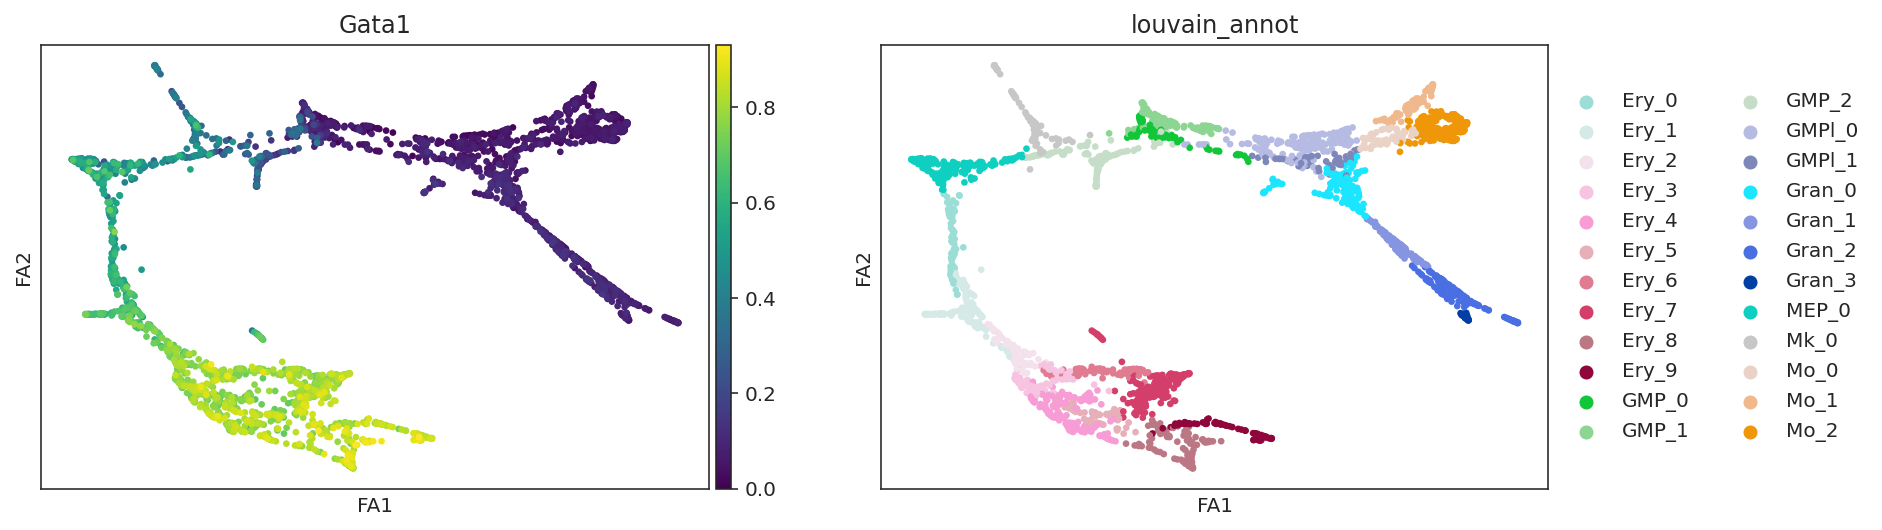

In [8]:
# Check gene expression 
goi = "Gata1"
sc.pl.draw_graph(oracle.adata, color=[goi, oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

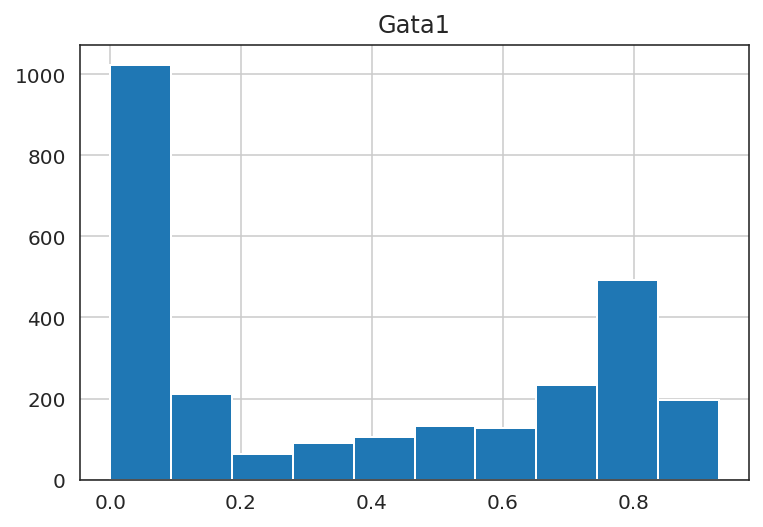

In [9]:
# Plot gene expression in histogram
sc.get.obs_df(oracle.adata, keys=[goi], layer="imputed_count").hist()
plt.show()

## 3.2. Calculate future gene expression after perturbation.

- You can use any gene expression value in the in silico perturbations, but please avoid extremely high values that are far from the natural gene expression range. The upper limit allowed is twice the maximum gene expression.


To simulate Gata1 KO, we will set Gata1 expression to 0.

In [10]:
# Enter perturbation conditions to simulate signal propagation after the perturbation.
oracle.simulate_shift(perturb_condition={goi: 0.0},
                      n_propagation=3)

## 3.3. Calculate transition probability between cells

- The steps above simulated tge global future gene expression shift after perturbation. This prediction is based on iterative calculations of signal propagation calculations within the GRN. Please look at our paper for more information.

- The next step calculates the probability of cell state transitions based on the simulation data. You can use the transition probabilities between cells to predict how cells will change after a perturbation.

- This transition probability will be used later.


In [11]:
# Get transition probability
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True, 
                                sampled_fraction=1)

# Calculate embedding 
oracle.calculate_embedding_shift(sigma_corr=0.05)

# 4. Visualization
## 4.1. Quiver plot: Show the direction of cell transition at single cell resolution

### Caution: It is very important to find the optimal `scale` parameter.

- We will need to adjust the `scale` parameter. Please seek to find the optimal `scale` parameter for the data based on your data.

- If the vectors are not visible, you can try a smaller `scale` parameter to magnify the vector length. However, if you see large vectors in the randomized results (right panel), it means that the scale parameter is too small.


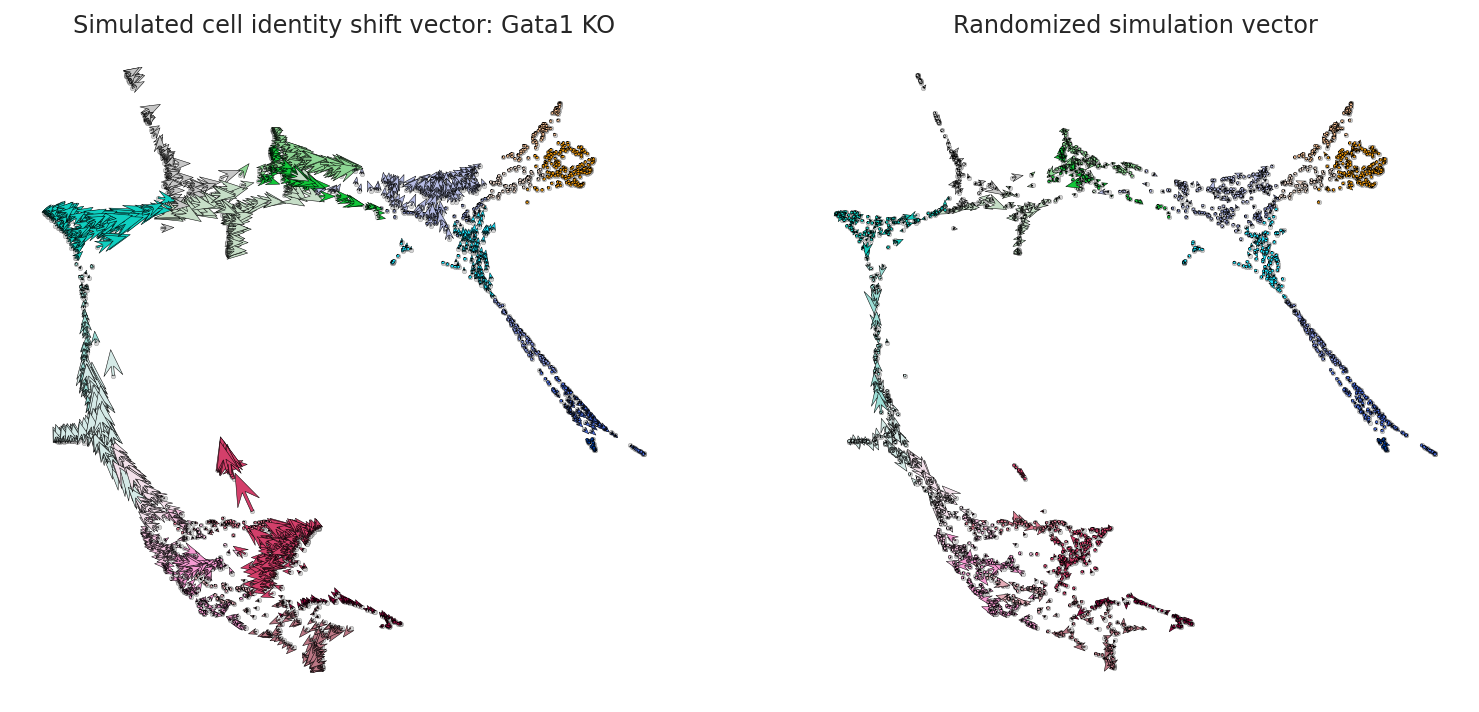

In [12]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale = 25
# Show quiver plot
oracle.plot_quiver(scale=scale, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_quiver_random(scale=scale, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

## 4.2. Vector field graph

We will visualize the simulation results as a vector field on a digitized grid. Single cell transition vectors are grouped by grid point.

### 4.2.1  Find parameters for n_grid and min_mass
`n_grid`: Number of grid points.

`min_mass`: Threshold value for the cell density. 
The appropriate values for these parameters depends on the data. Please find appropriate values using the helper functions below.
 


In [13]:
# n_grid = 40 is a good starting value.
n_grid = 40 
oracle.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)

Please run `oracle.suggest_mass_thresholds()` to display a range of `min_mass` parameter values and choose a value to fit the data.

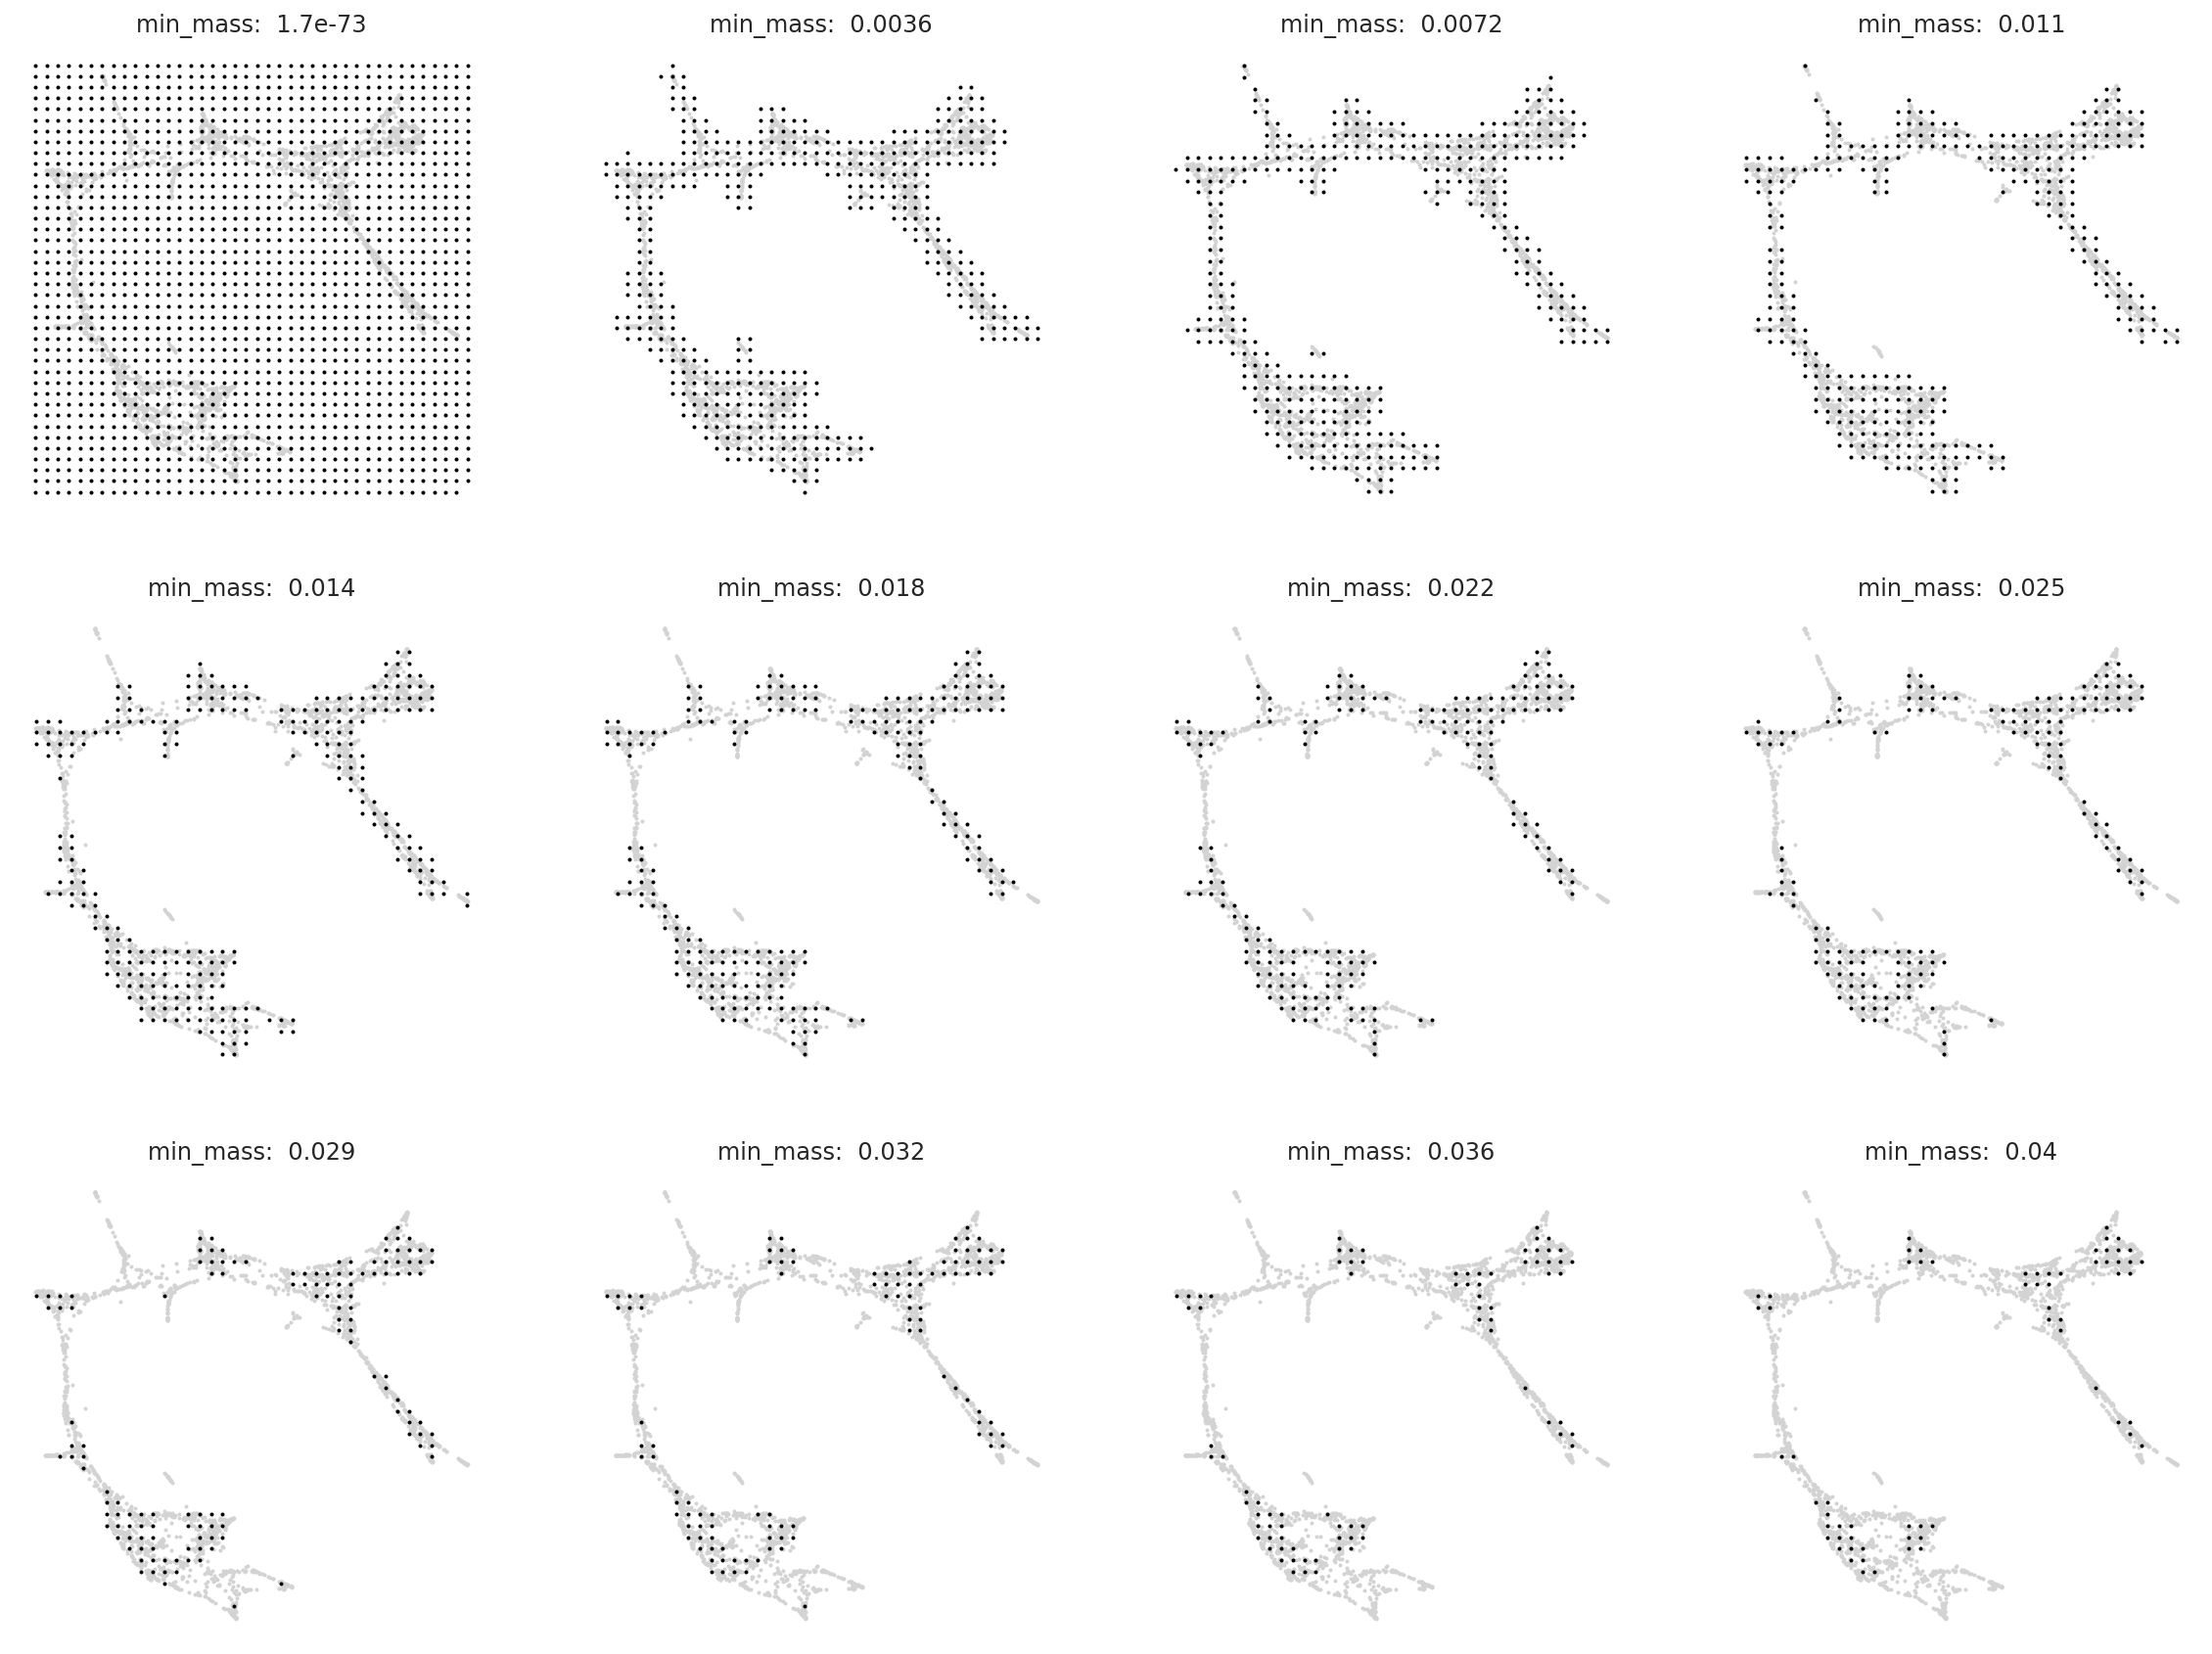

In [14]:
# Search for best min_mass.
oracle.suggest_mass_thresholds(n_suggestion=12)

According to the results, the optimal `min_mass` is around 0.011.

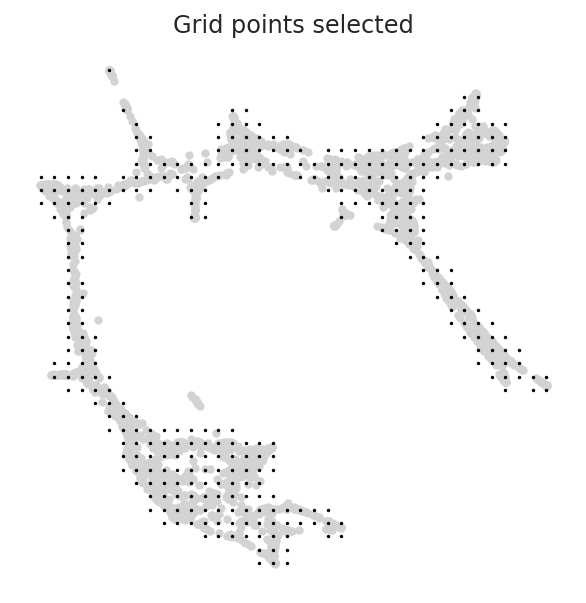

In [15]:
min_mass = 0.01
oracle.calculate_mass_filter(min_mass=min_mass, plot=True)

### 4.2.2  Plot vector fields

- Again, we need to adjust the `scale` parameter. Please seek to find the optimal `scale` parameter that provides good visualization.

- If you don't see any vector, you can try the smaller `scale` parameter to magnify the vector length. However, if you see large vectors in the randomized results (right panel), it means the scale parameter is too small.



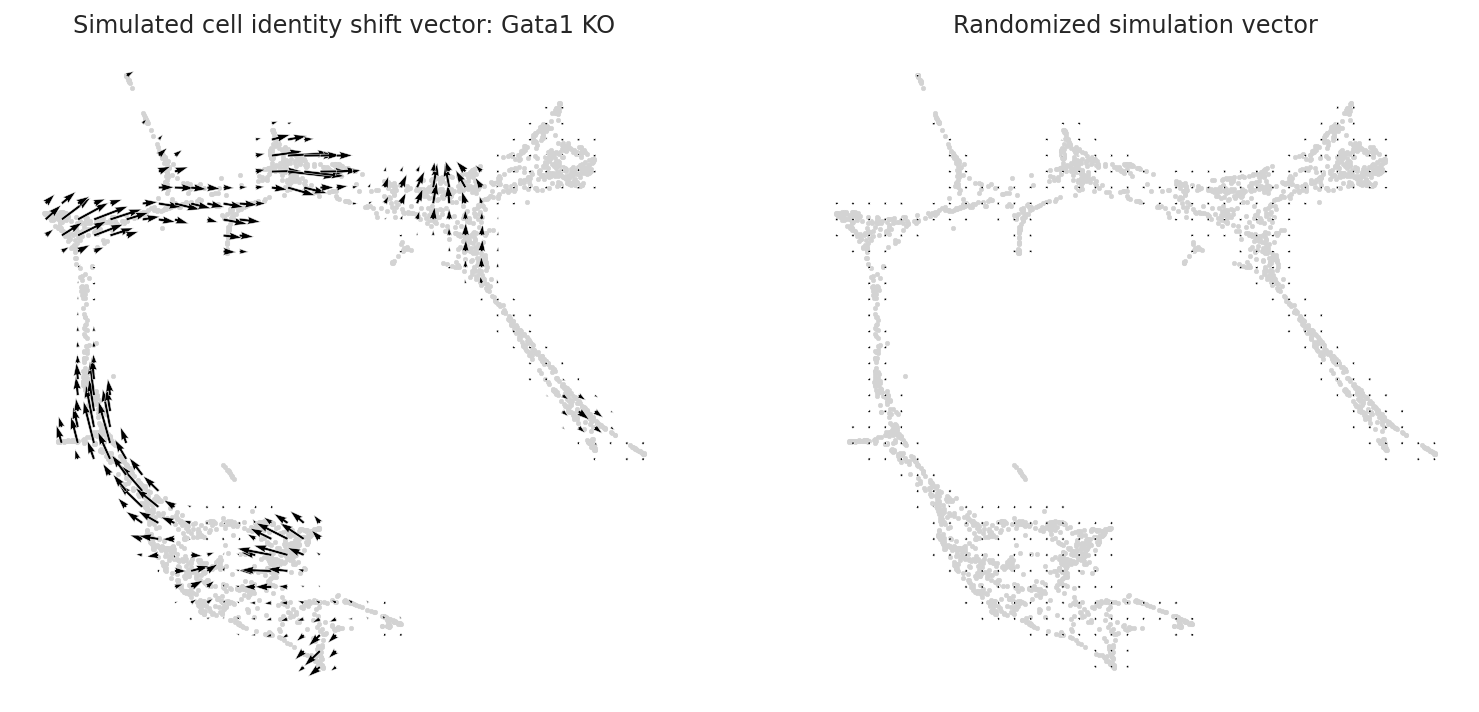

In [16]:
fig, ax = plt.subplots(1, 2,  figsize=[13, 6])

scale_simulation = 0.5
# Show quiver plot
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax[0])
ax[0].set_title(f"Simulated cell identity shift vector: {goi} KO")

# Show quiver plot that was calculated with randomized graph.
oracle.plot_simulation_flow_random_on_grid(scale=scale_simulation, ax=ax[1])
ax[1].set_title(f"Randomized simulation vector")

plt.show()

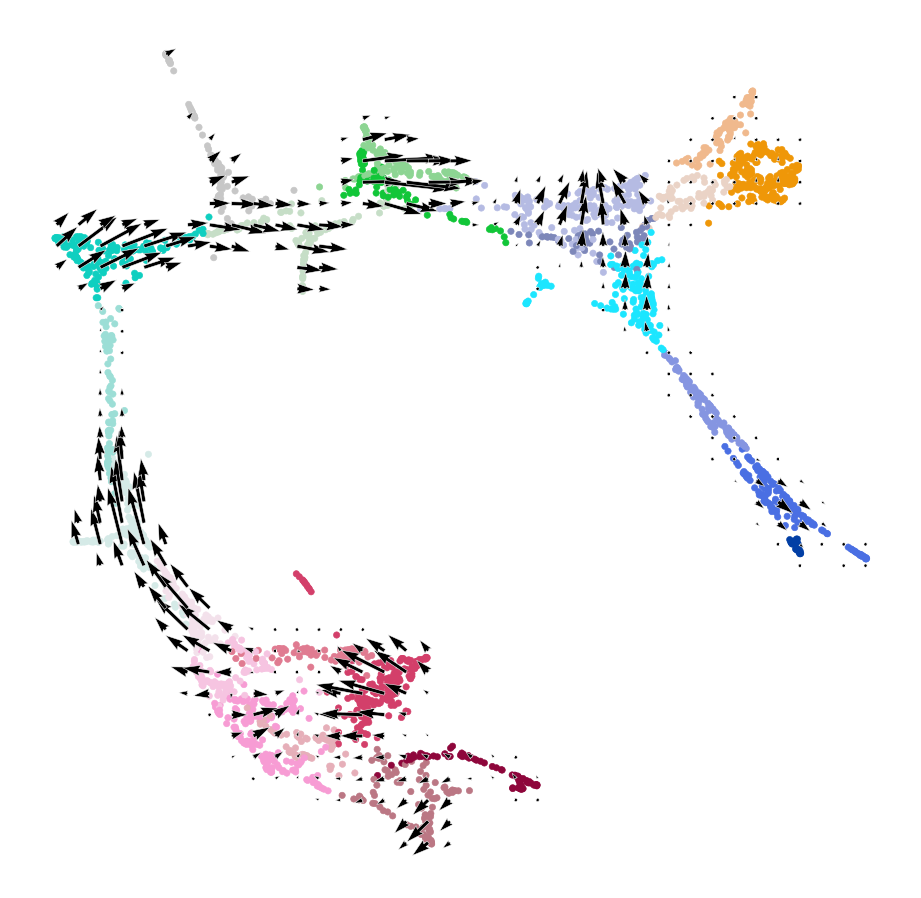

In [17]:
# Plot vector field with cell cluster 
fig, ax = plt.subplots(figsize=[8, 8])

oracle.plot_cluster_whole(ax=ax, s=10)
oracle.plot_simulation_flow_on_grid(scale=scale_simulation, ax=ax, show_background=False)

# 5. Compare simulation vector with development vectors


## 5.0. Method overview

- As shown above, we can simulate how TF perturbations affect cell identity and visualize the results as a vector field map.

- To interpret the results, it is necessary to take into account the direction of natural differentiation. We will compare the simulated perturbation vectors with the developmental gradient vectors. By comparing them, we can intuitively understand how TFs impact cell fate determination during development. This perspective is also important for estimating the experimental perturbation results.

- Here, we will calculate the development vector field using **pseudotime gradient** as follows.
 
 1. Transfer the **pseudotime data** into an n x n digitized grid.

 2. Calculate the 2D gradient of pseudotime to get vector field.

 3. Compare the in silico TF perturbation vector field with the development vector field by calculating inner product between these two vectors. 


-  Note: Other methods may be used to represent a continuous scRNA-seq trajectory flow. For example, RNA velocity analysis is a good way to estimate the direction of cell differentiation. Choose the method that best suits your data.



## 5.1 Prepare pseudotime data

In the analysis below, we will use **pseudotime** data. Pseudotime data is included in the demo data. **If you are analyzing your own scRNA-seq data, please calculate pseudotime before starting this analysis.**

Refer to the following link below to see an example about calculating pseudotime for scRNA-seq data. 
https://morris-lab.github.io/CellOracle.documentation/tutorials/pseudotime.html




## 5.2. Check data

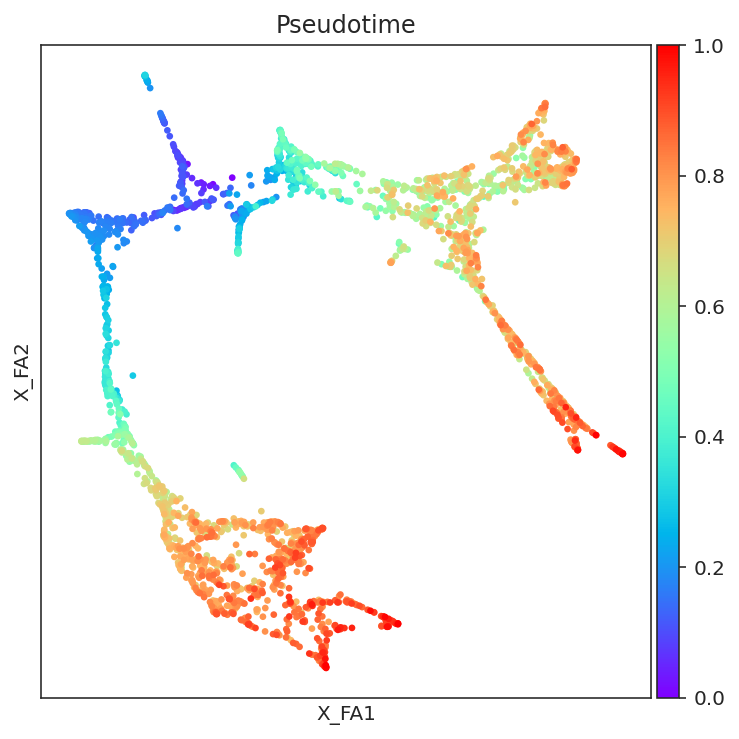

In [18]:
# Visualize pseudotime
fig, ax = plt.subplots(figsize=[6,6])

sc.pl.embedding(adata=oracle.adata, basis=oracle.embedding_name, ax=ax, cmap="rainbow",
                color=["Pseudotime"])

## 5.3. Make Gradient_calculator object

In [19]:
from celloracle.applications import Gradient_calculator

# Instantiate Gradient calculator object
gradient = Gradient_calculator(oracle_object=oracle, pseudotime_key="Pseudotime")

We need to set `n_grid` and `min_mass` for the pseudotime grid point calculation too.
`n_grid`: Number of grid point.

We already know approproate values for them. Please set the same values as step 4.2.1 above.


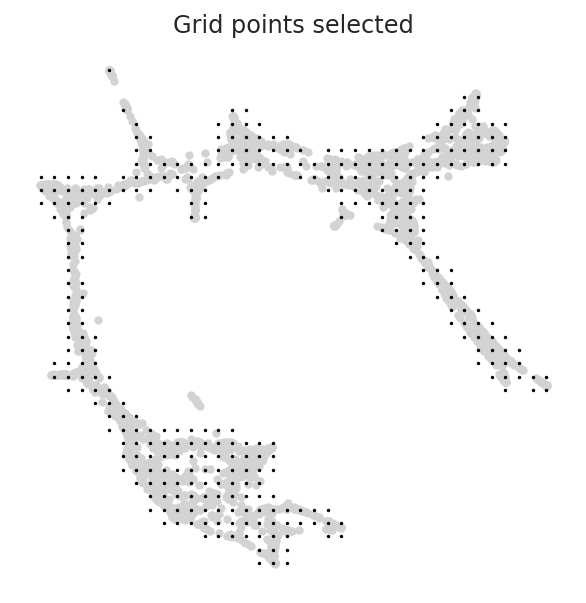

In [20]:
gradient.calculate_p_mass(smooth=0.8, n_grid=n_grid, n_neighbors=200)
gradient.calculate_mass_filter(min_mass=min_mass, plot=True)

## 5.4 Transfer pseudotime values to the grid points.

Next, we convert the pseudotime data into grid points. For this calculation we can chose one of two methods.

- `knn`: K-Nearesr Neighbor regression. You will need to set number of neighbors.
  Please adjust `n_knn` for best results.This will depend on the population size and density of your scRNA-seq data.

 `gradient.transfer_data_into_grid(args={"method": "knn", "n_knn":50})`



- `polynomial`: Polynomial regression using x-axis and y-axis of dimensional reduction space.

 In general, this method will be more robust. Please use this method if knn method does not work.
 `n_poly` is the number of degrees for the polynomial regression model. Please try to find appropriate`n_poly` searching for best results.
 
 `gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3})`

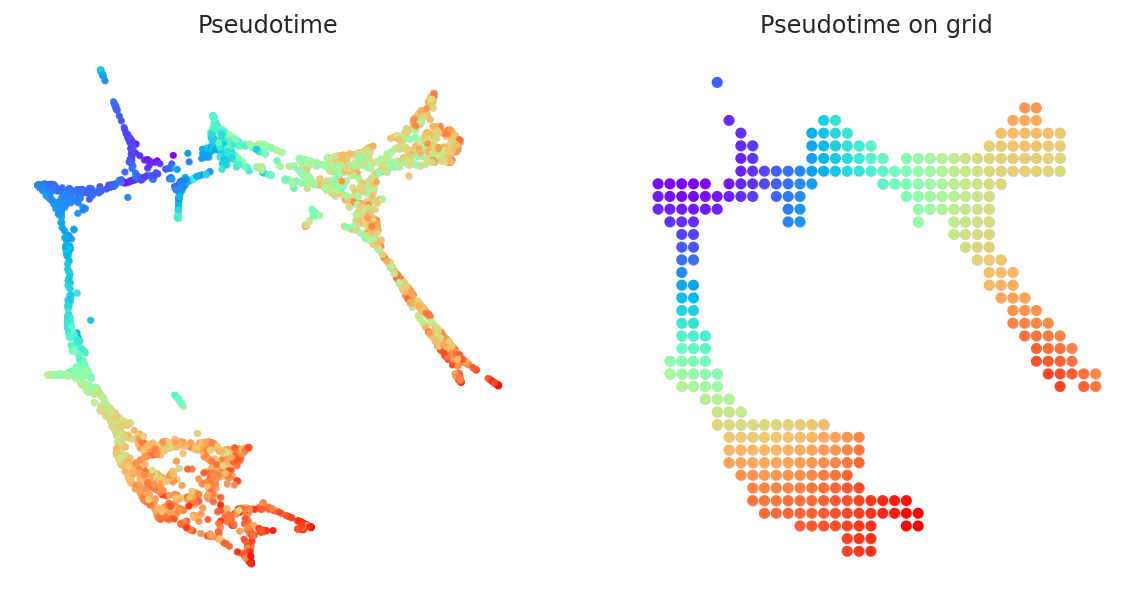

In [21]:
gradient.transfer_data_into_grid(args={"method": "polynomial", "n_poly":3}, plot=True)

## 5.5. Calculate Gradient vectors

Calculate the 2D vector map to represents the pseudotime gradient. After the gradient calculation, the length of the vector will be normalized automatically.

Please adjust the `scale` parameter to adjust vector length visualization.

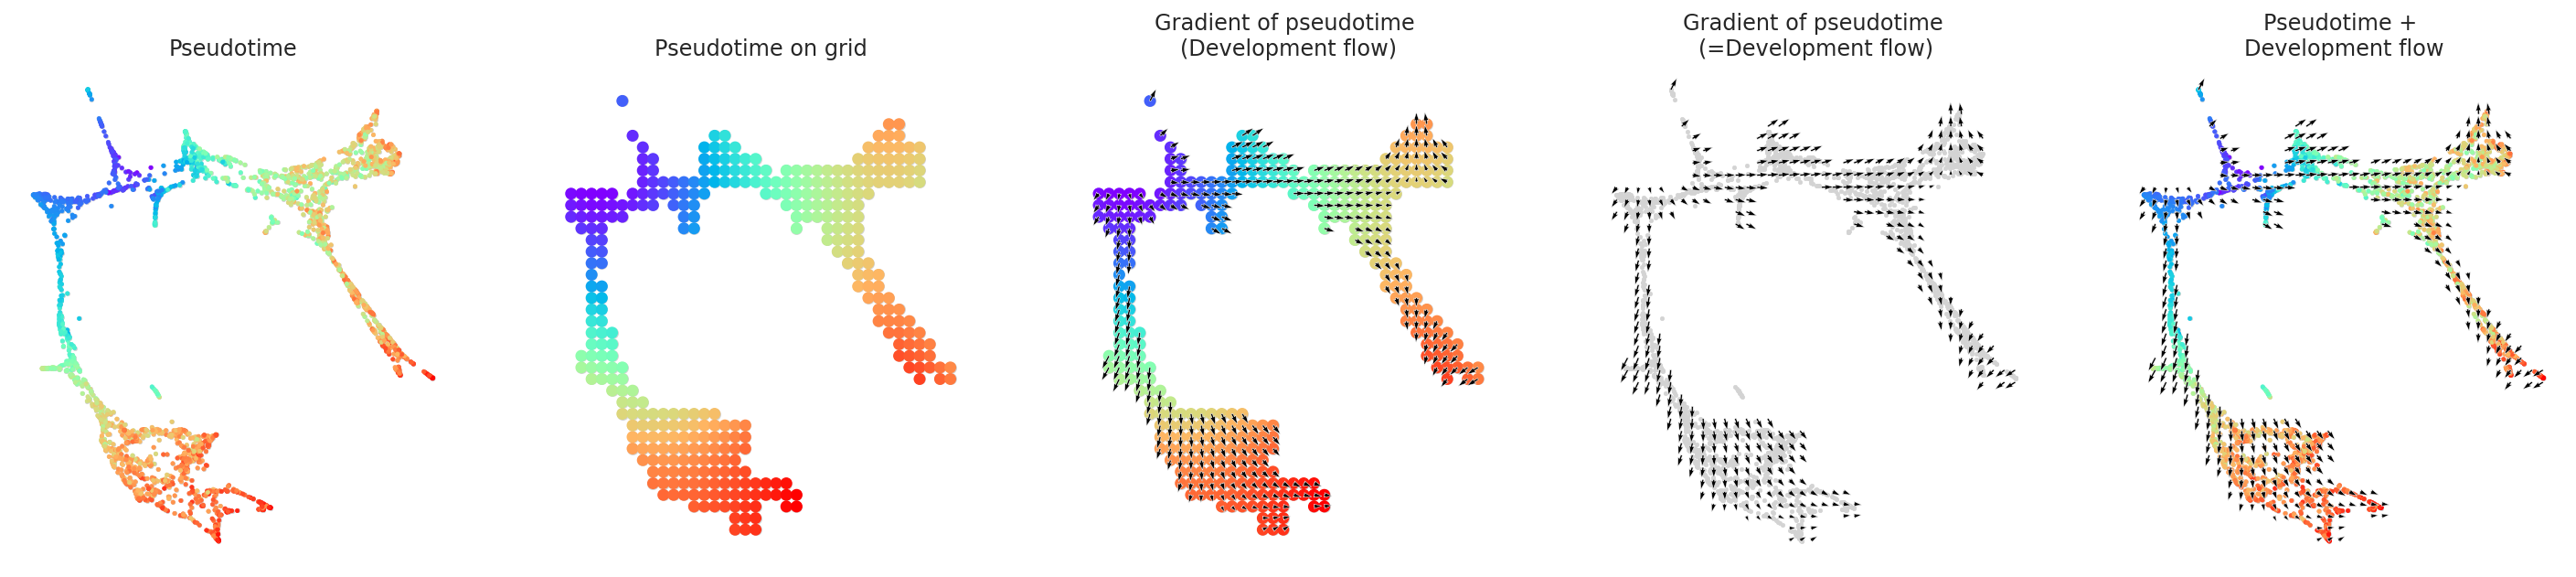

In [22]:
# Calculate graddient
gradient.calculate_gradient()

# Show results
scale_dev = 40
gradient.visualize_results(scale=scale_dev, s=5)

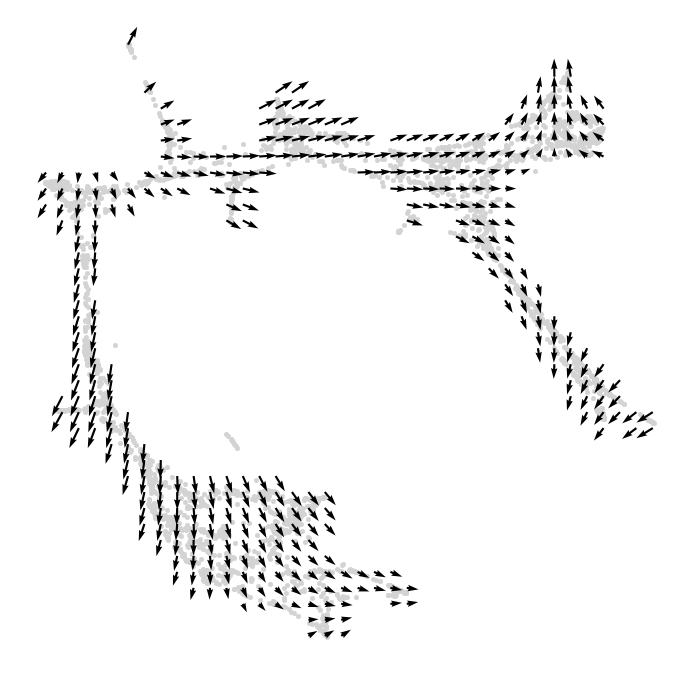

In [23]:
# Visualize results
fig, ax = plt.subplots(figsize=[6, 6])
gradient.plot_dev_flow_on_grid(scale=scale_dev, ax=ax)

In [24]:
# Save gradient object if you want.
#gradient.to_hdf5("Paul_etal.celloracle.gradient")

## 5.6. Calculate Inner product between two vectors

We will use the inner product calculations to quantitatively compare the 2D  developmental flow and perturbation simulation vectors.
> If you are not familiar with Inner product / Dot product, please see https://en.wikipedia.org/wiki/Dot_product

- **The inner product represents the similarity between two vectors.** 

- Using the inner product, we compare the 2D vector field of perturbation simulation and development flow. 

- The inner product will be a positive value when two vectors are pointing in the same direction.
- Conversely, the inner product will be a negative value when two vectors are pointing in the opposing directions.

<img src="https://raw.githubusercontent.com/morris-lab/CellOracle/master/docs/demo_data/innerproduct_explantion_1.png">

- The length of the vectors also affects the magnitude of inner product value.


In summary, we quantitatively compare the directionality and size of vectors between perturbation simulation and natural differentiation using inner product, and we define the score as **perturbation score (PS)**.

- **<span style="color: purple; "> A negative PS </span>** means that the TF perturbation would **<span style="color: purple; "> block differentiation </span>**.

- **<span style="color: green; "> A positive PS</span>** means that the TF perturbation would **<span style="color: green; "> promote differentiation </span>**.



In [25]:
from celloracle.applications import Oracle_development_module

# Make Oracle_development_module to compare two vector field
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle)


# Calculate inner produc scores
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

## 5.7. Show results

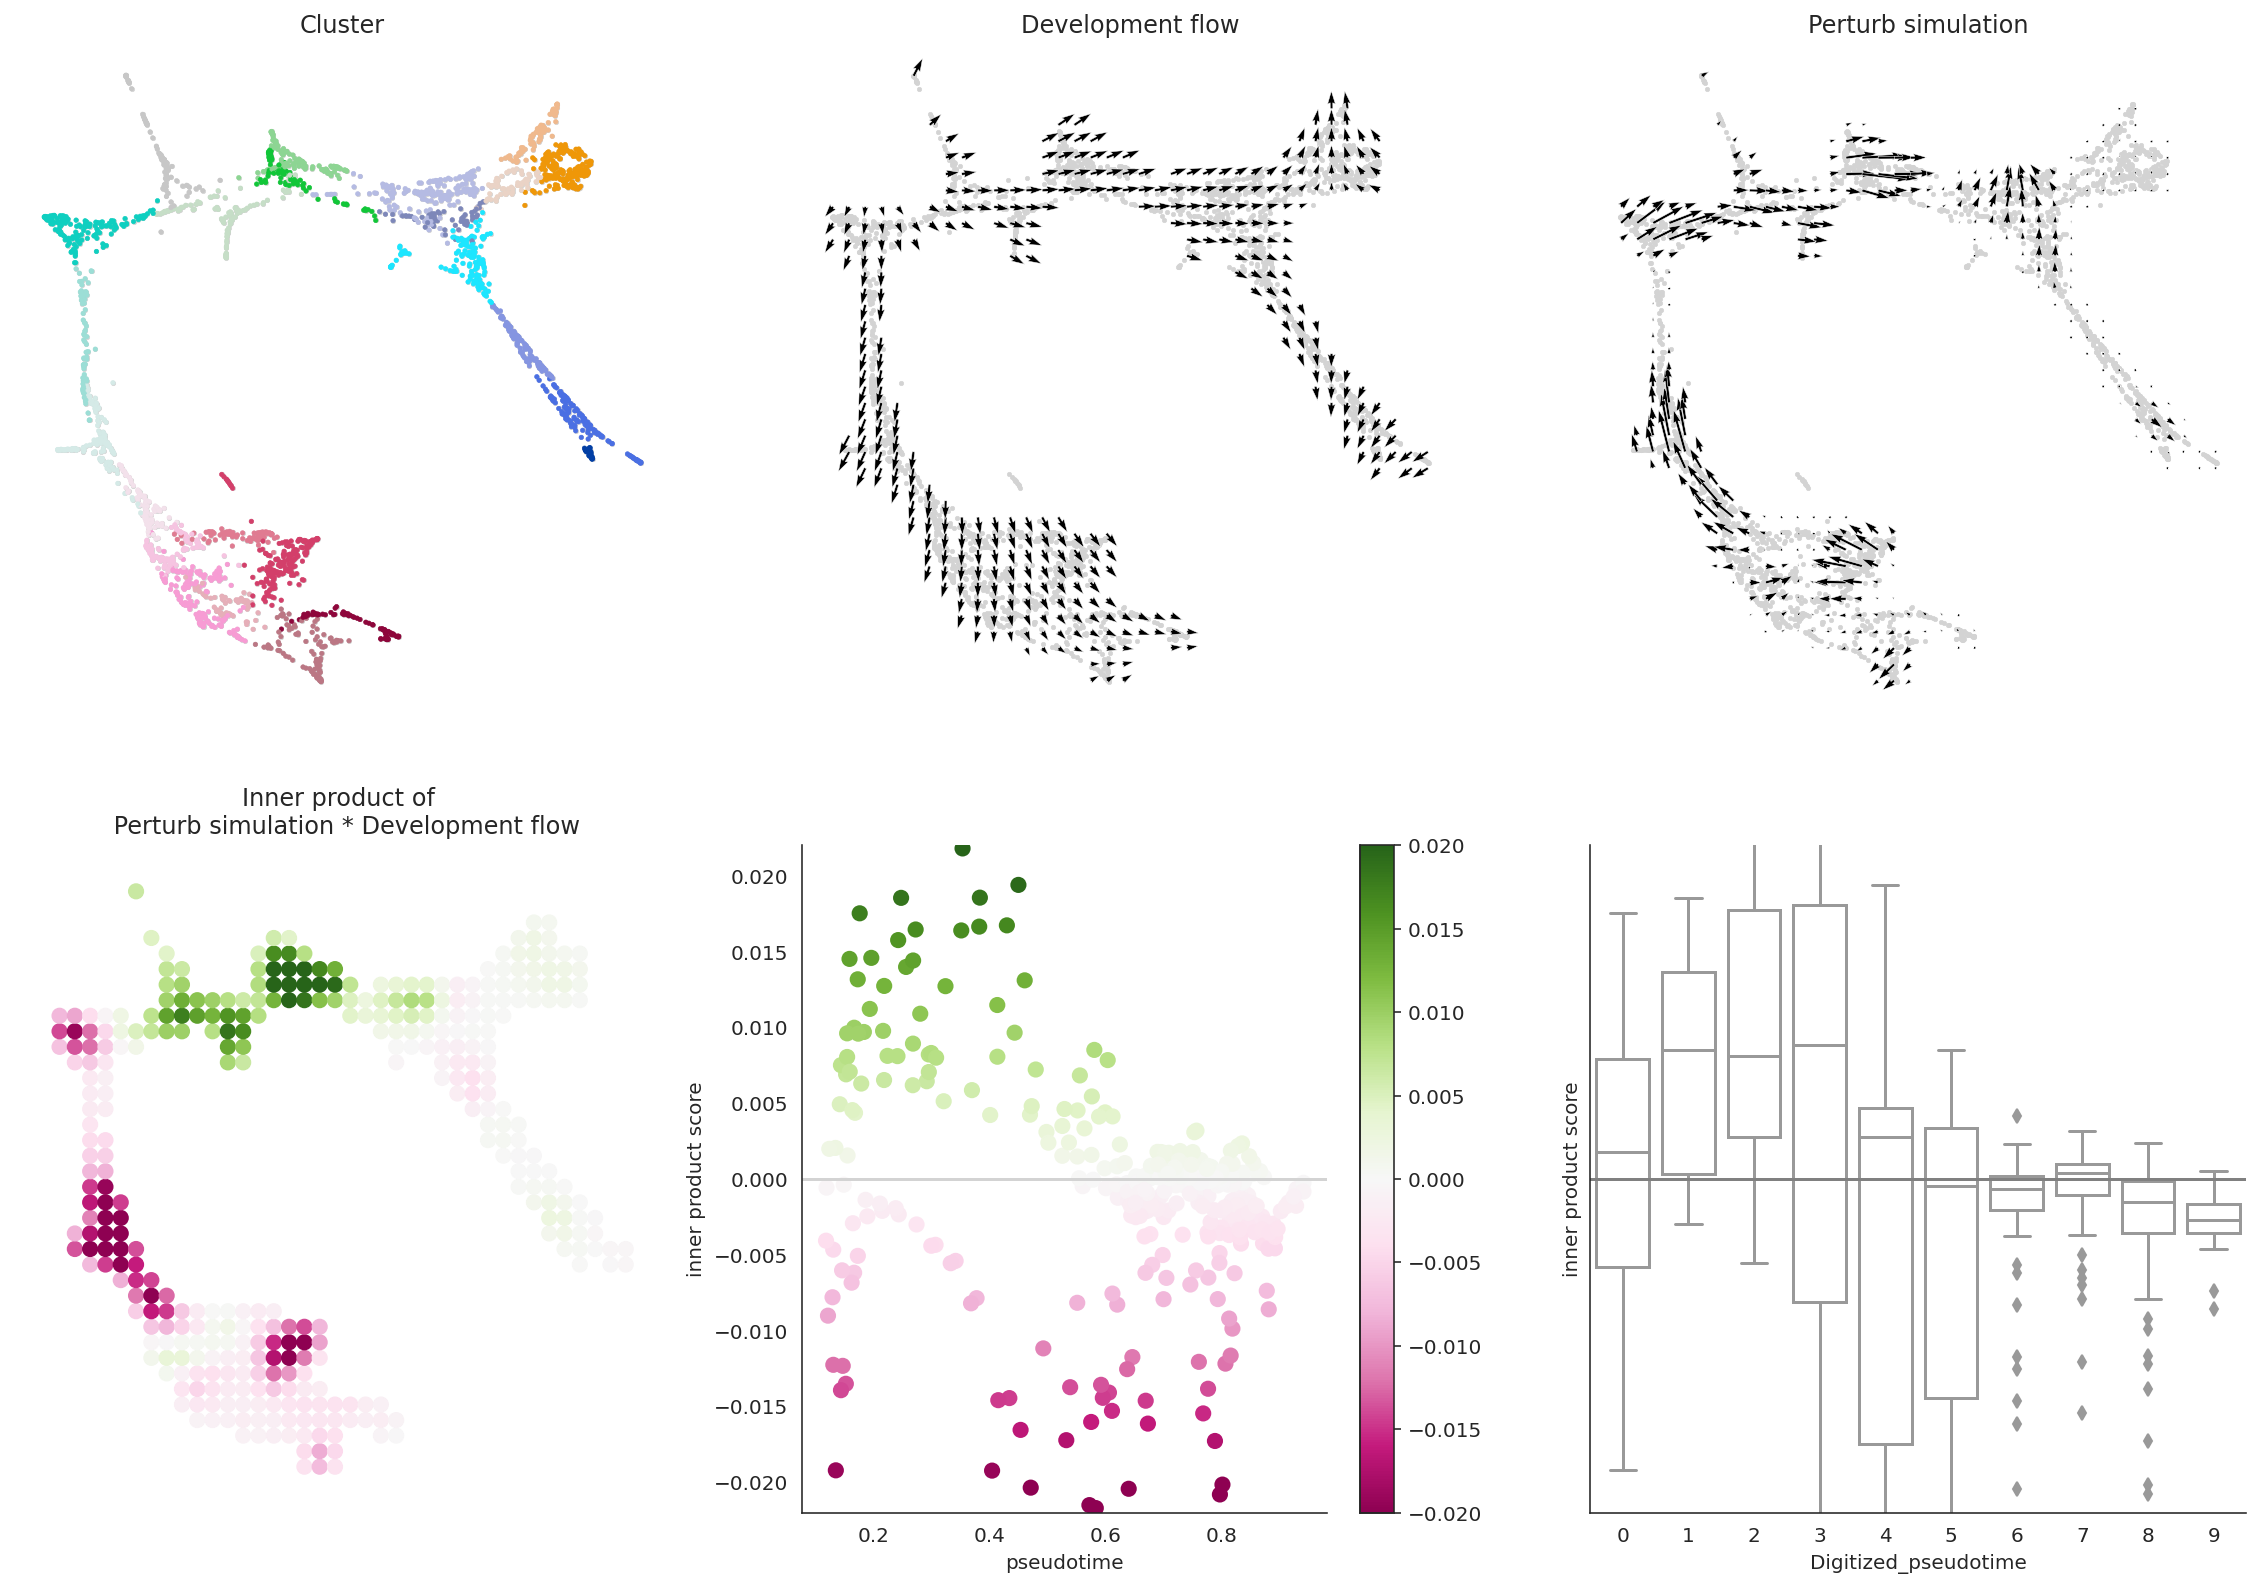

In [26]:
# Let's visualize the results 
dev.visualize_development_module_layout_0(s=5, 
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev, 
                                          vm=0.02)

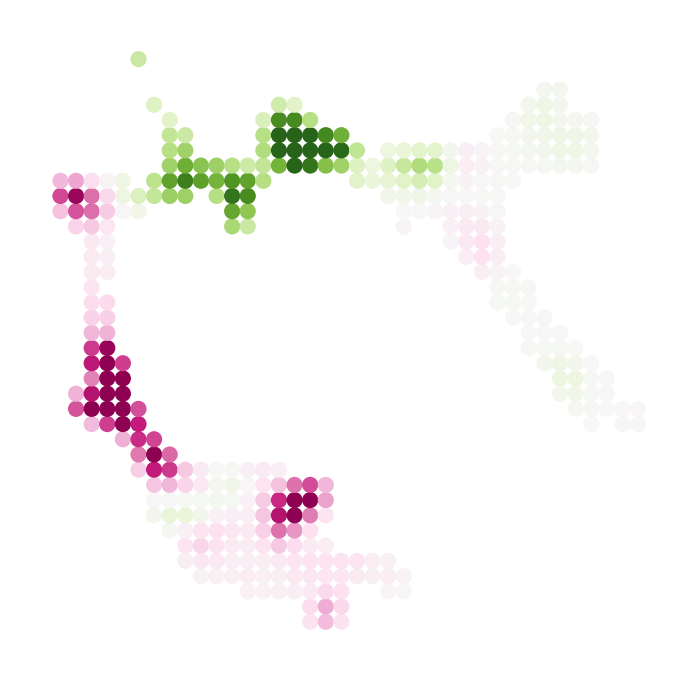

In [27]:
# Show perturbation scores
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=0.02, s=50, ax=ax)

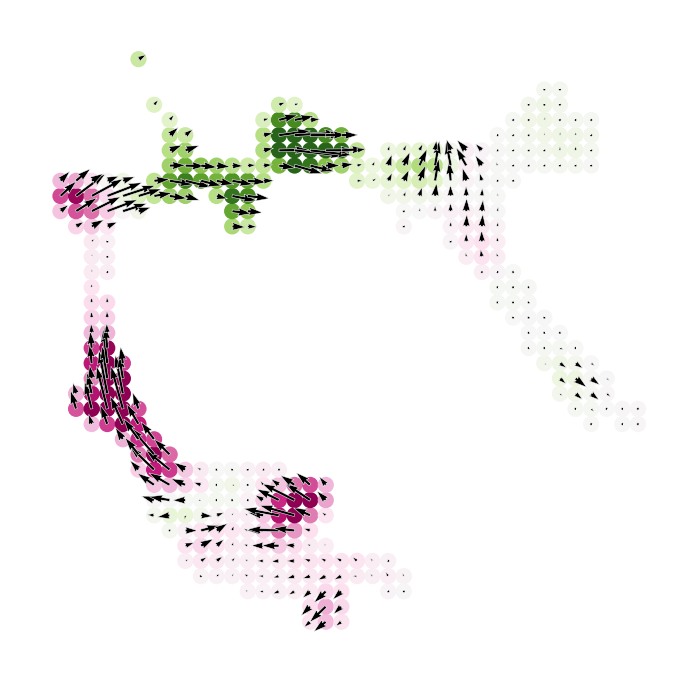

In [28]:
# Show perturbation scores with perturbation simulation vector field
fig, ax = plt.subplots(figsize=[6, 6])
dev.plot_inner_product_on_grid(vm=0.02, s=50, ax=ax)
dev.plot_simulation_flow_on_grid(scale=scale_simulation, show_background=False, ax=ax)

# 6. Focus on a single development lineage to interpret the results in detail

So far, we have used the `Oracle_development_module` to analyze the whole cell population.
However, the `Oracle_development_module` can also analyze specific subpopulations.

In this example, we will analyze the MEP lineage.


In [29]:
# Get cell index list for the cells of interest
clusters = ['Ery_0', 'Ery_1', 'Ery_2', 'Ery_3', 'Ery_4', 'Ery_5', 'Ery_6',
            'Ery_7', 'Ery_8', 'Ery_9', 'MEP_0', 'Mk_0']
cell_idx = np.where(oracle.adata.obs["louvain_annot"].isin(clusters))[0]

# Check index
print(cell_idx)

[   0    2    4 ... 2666 2668 2670]


In [30]:
dev = Oracle_development_module()

# Load development flow
dev.load_differentiation_reference_data(gradient_object=gradient)

# Load simulation result
dev.load_perturb_simulation_data(oracle_object=oracle, 
                                 cell_idx_use=cell_idx, # Enter cell id list
                                 name="Lineage_MEP" # Name of this cell group. You can enter any name.
                                 )

# Calculation
dev.calculate_inner_product()
dev.calculate_digitized_ip(n_bins=10)

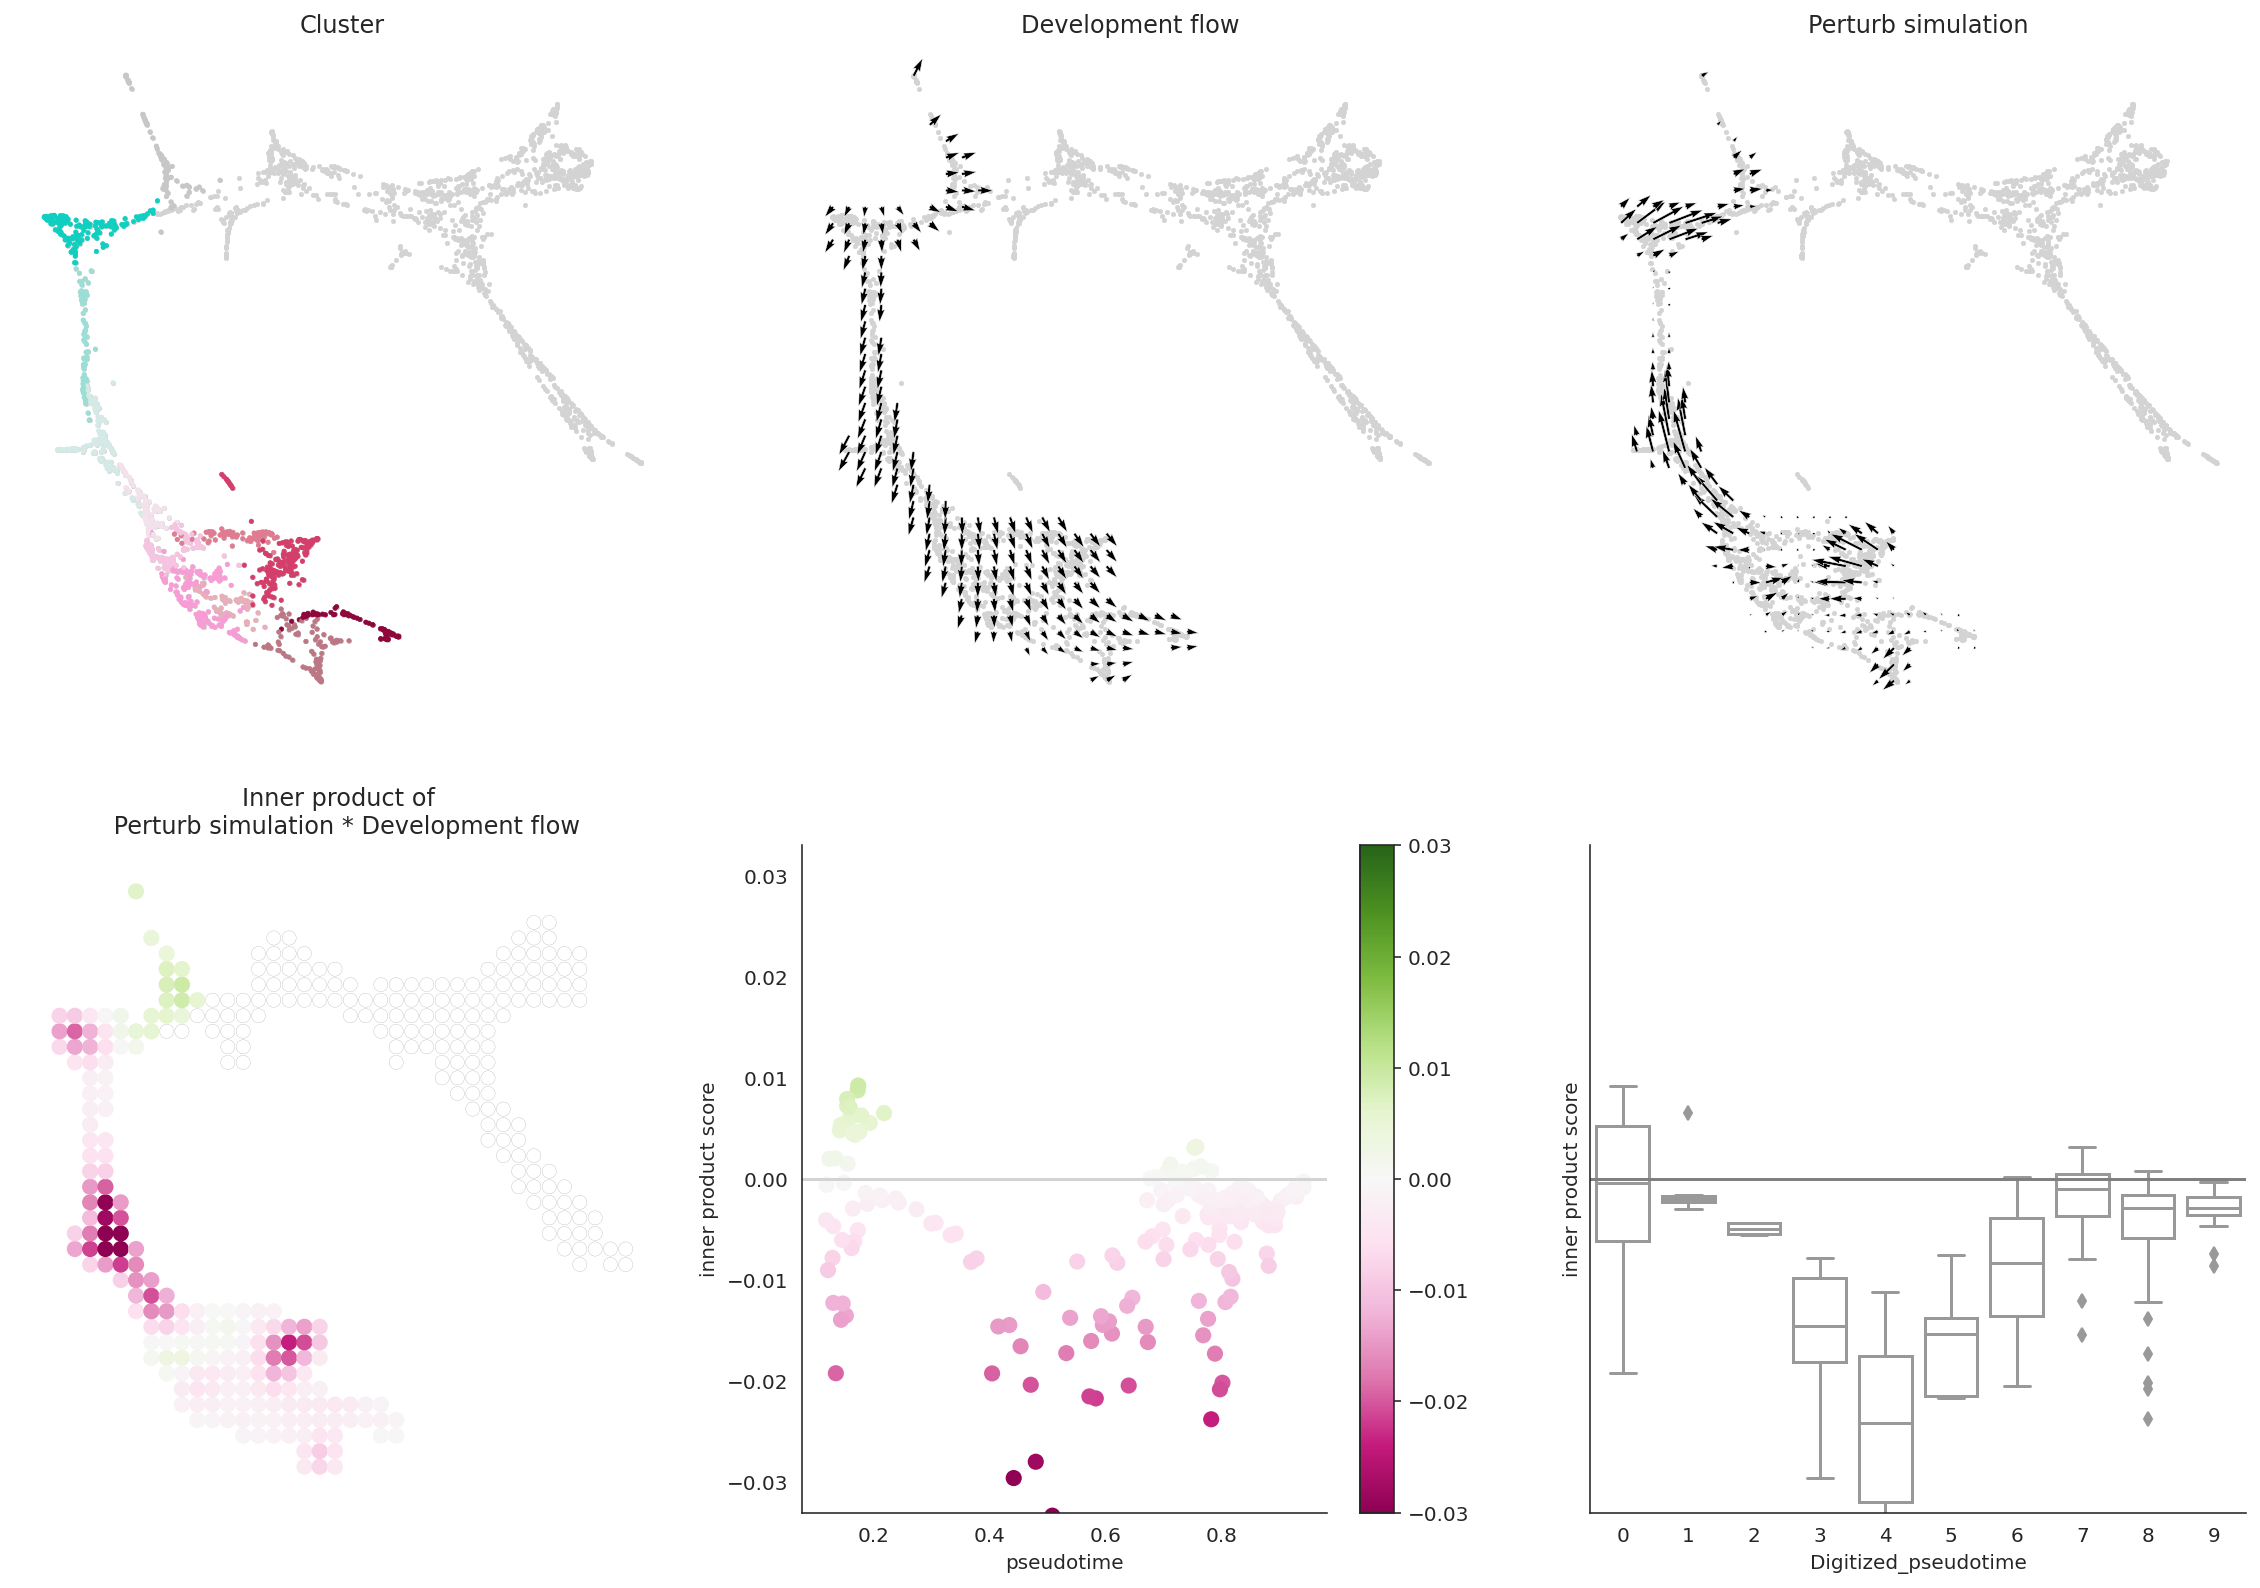

In [31]:
# Let's visualize the results 
dev.visualize_development_module_layout_0(s=5, 
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev, 
                                          vm=0.03)

**Attention: We have changed the default color scheme for the perturbation score visualization at CellOracle = 0.9.0.** 
If you would like to use the previous blue and red color scheme, please run the following command to change the color scheme.



In [32]:
from celloracle.visualizations.config import CONFIG
CONFIG["cmap_ps"] = "coolwarm"

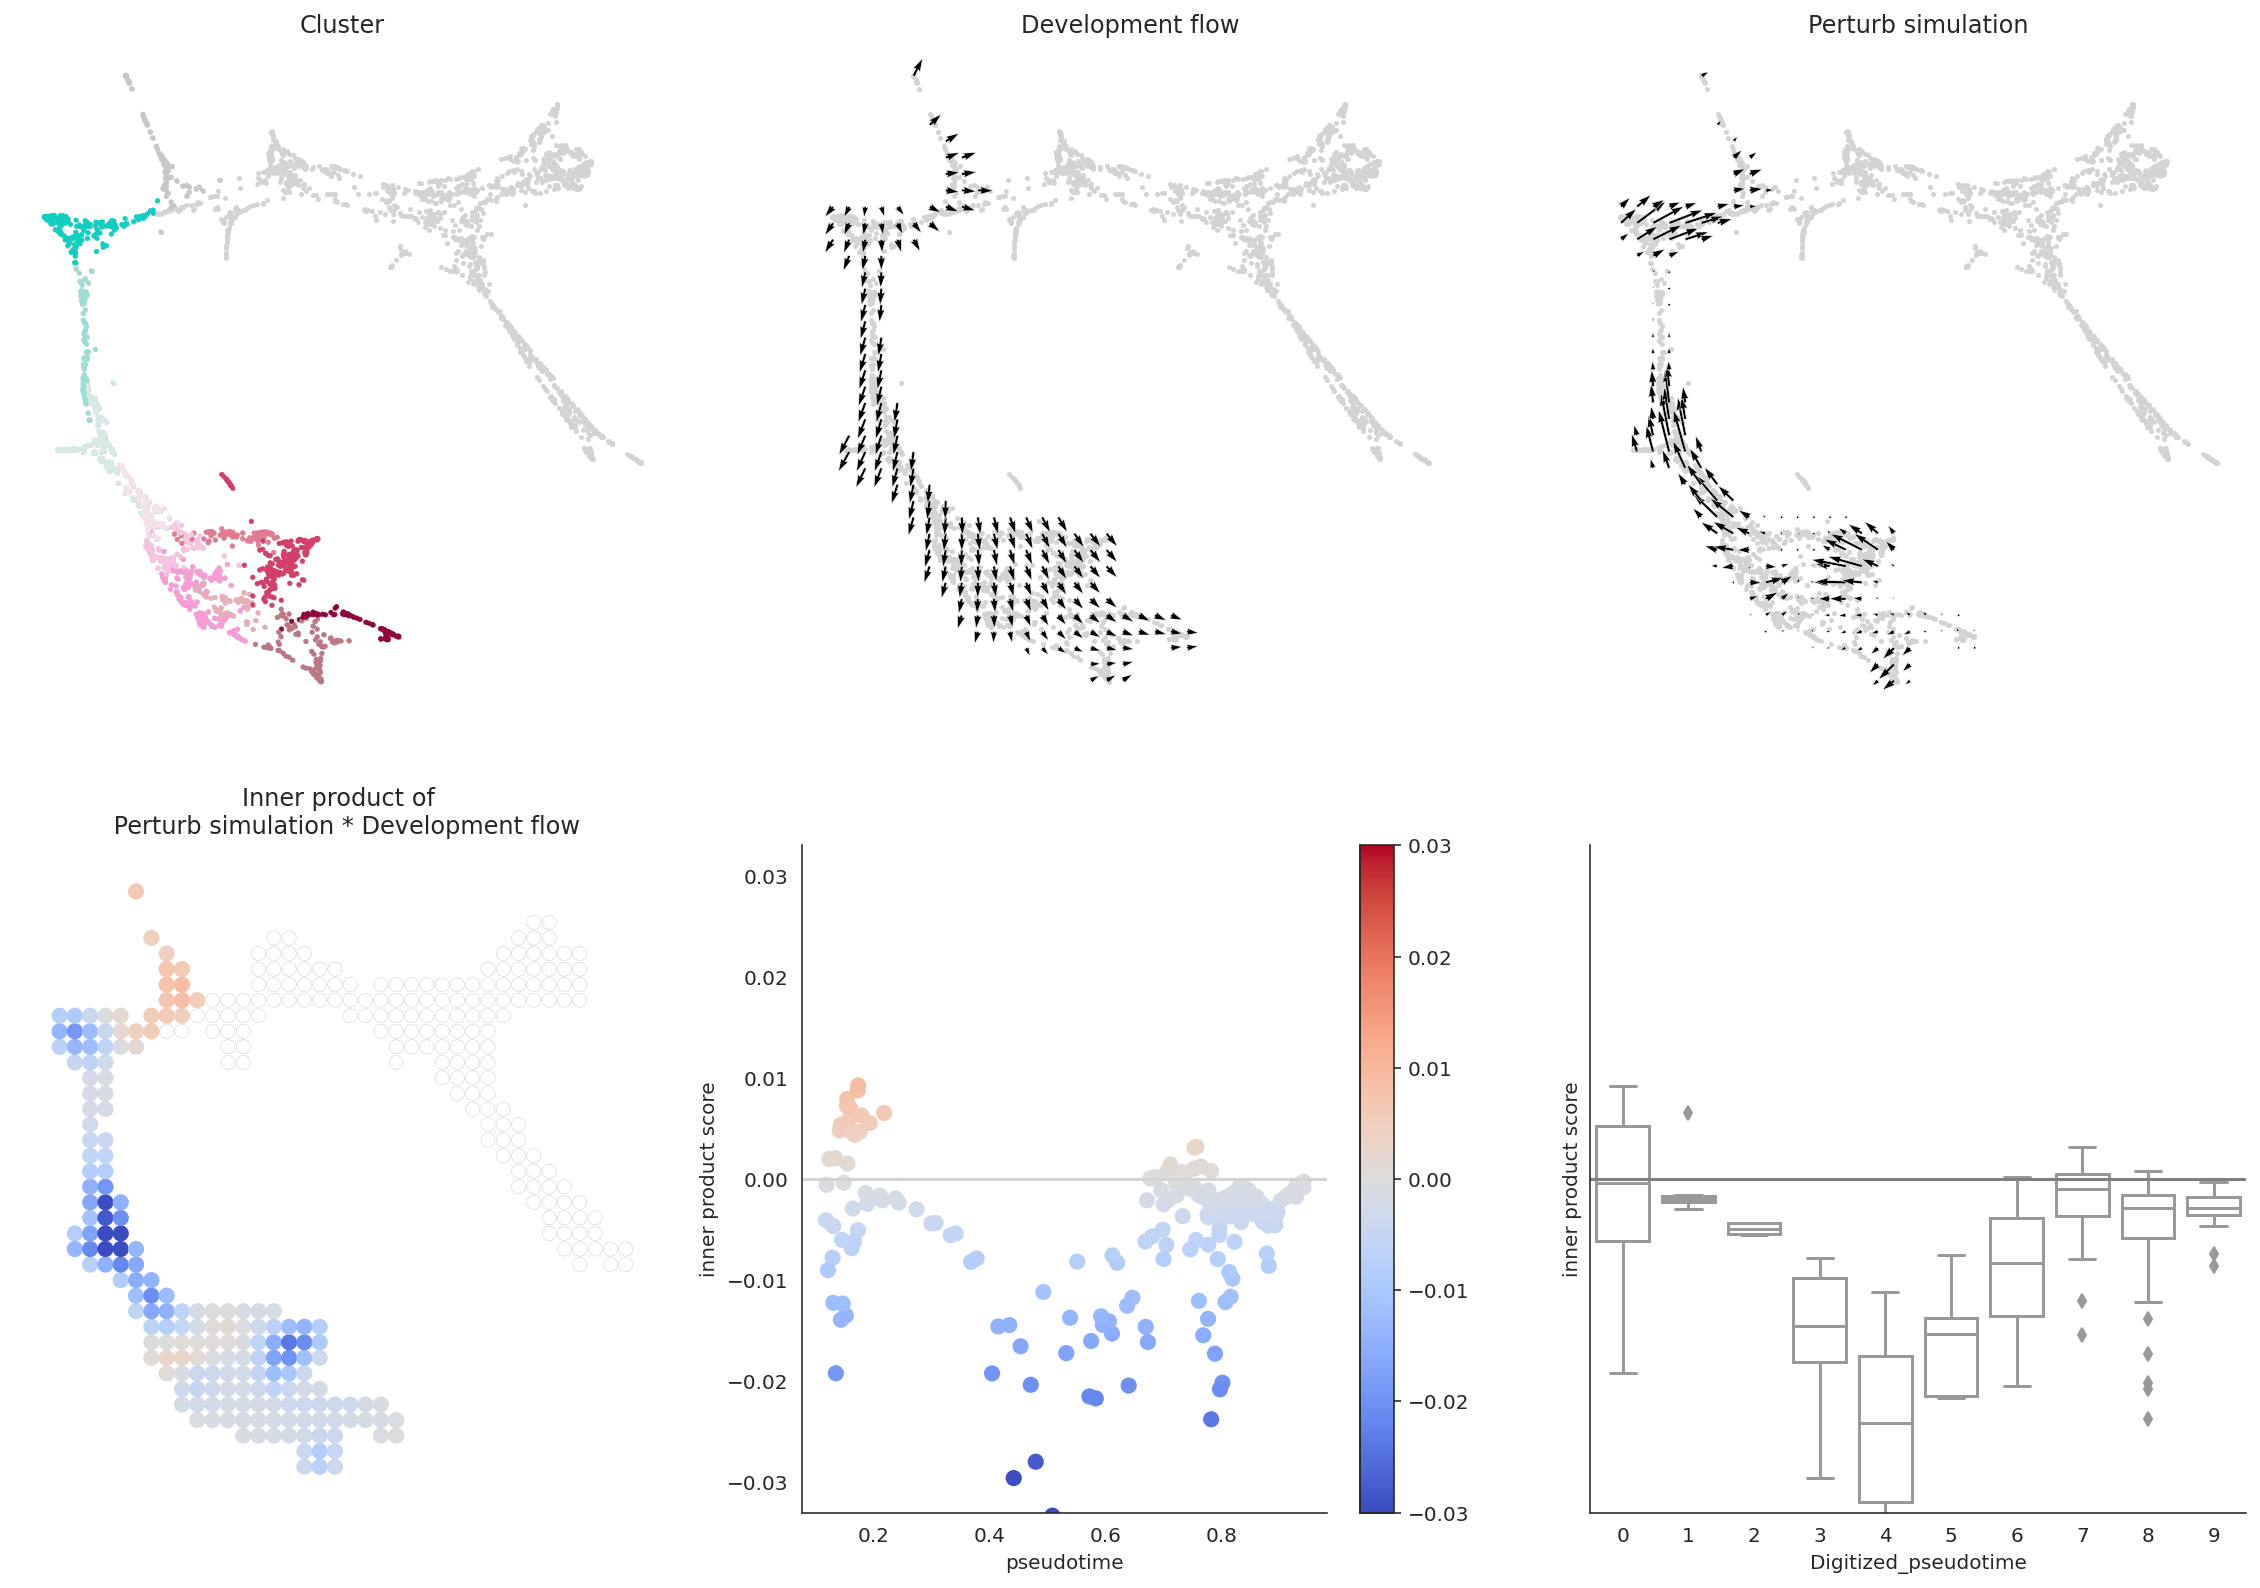

In [33]:
dev.visualize_development_module_layout_0(s=5, 
                                          scale_for_simulation=scale_simulation,
                                          s_grid=50,
                                          scale_for_pseudotime=scale_dev, 
                                          vm=0.03)